In [1]:
%config IPCompleter.greedy=True

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [3]:
#test utils

def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)

In [4]:
import weapon_data as weapons

network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=14,
         n_hidden_2=15,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.AdamOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = lambda x : tf.nn.tanh(x)
num_epochs = 10
batch_size = 1
epoch_debug_step = 1
    
with tf.Session() as sess:
    weapon_data = weapons.DataSet(seed=19071991) 
    network_architecture['n_input'] = weapon_data.num_features
  
    network = vae.get_new_trained(sess, weapon_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step, )


Epoch:0001, cost=24.065410511
Epoch:0002, cost=21.426480168
Epoch:0003, cost=18.720452199
Epoch:0004, cost=17.992361365
Epoch:0005, cost=17.461620495
Epoch:0006, cost=16.527056140
Epoch:0007, cost=15.894437687
Epoch:0008, cost=13.634579217
Epoch:0009, cost=13.352891308
Epoch:0010, cost=13.297641828
Trained model saved! You can find it in './trained_vae/model.ckpt'


In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
        
    weapon_data = weapons.DataSet(seed=19071991) 
    samples = weapon_data.next_batch(batch_size)
    x_reconstructed = network.encode_and_decode(samples)
    
    print(samples)
    print(x_reconstructed)
    
    print_decoded_tensors_as_dict(weapon_data, np.concatenate((samples,x_reconstructed), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
[[-0.70326645 -0.48674743 -0.30162464 -0.29826301 -0.22336265  1.3003496
  -0.75793673 -0.59816232  0.19378264 -1.11913753 -0.86609068 -0.28002455
   0.55030494  2.19514536  3.58362519  0.55859823 -0.28577464 -0.32322997
  -0.50421948 -0.54611868 -0.36023741 -0.52522573  2.45919073 -0.2672411 ]]
[[-0.5739281  -0.5004911  -0.2232849  -0.4793448  -0.31418145  0.7893847
  -0.2096858  -0.5528208   0.79634416 -0.52705866 -0.71010613 -0.30770922
  -0.02856892  0.40352023  0.02580725  0.9818002  -0.33743834 -0.41982293
   0.01289137 -0.10670032  0.5210898  -0.44646063  0.5389442  -0.30858636]]
damages_first = ['26.5', '29.701527502044016']
damages_last = ['20.0', '19.670367231007884']
dmg_distances_first = ['11.0', '12.164344293262257']
dmg_distances_last = ['50.0', '42.448766580560125']
drag = ['0.0024999999441206455', '0.002390108588928173']
firemode_Automatic = ['1.0', '0.7530823385692023']
firemode_Semi-Automatic = ['0.0', '

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


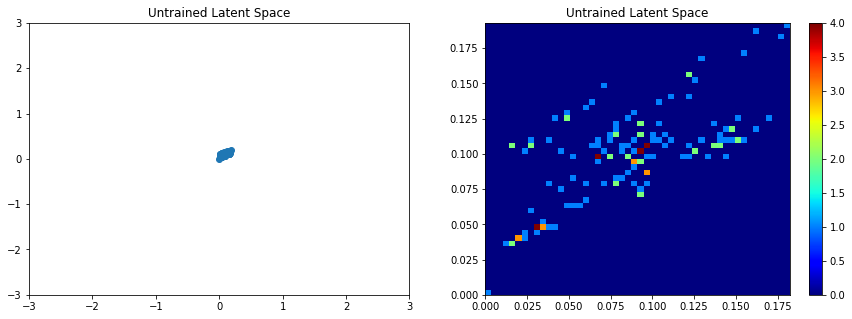

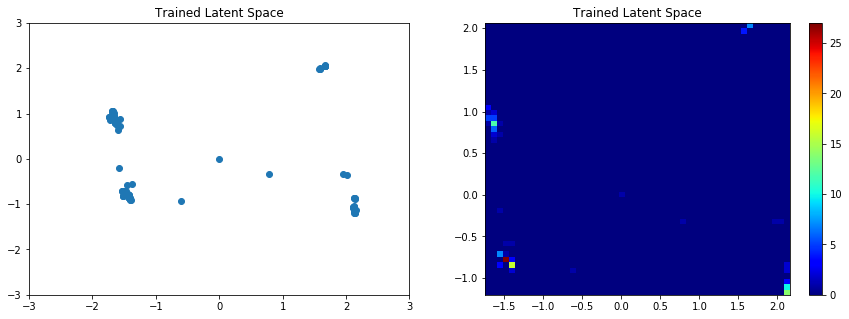

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_z_distribution(vae_model, title, z_mean=True):
    all_z = np.zeros((1,network_architecture['n_z']))
        
    weapon_data = weapons.DataSet(seed=19071991) 
    total_batch = int(weapon_data.num_examples / batch_size) 

    # Loop over all batches
    for i in range(total_batch):
        batch = weapon_data.next_batch(batch_size)
        z_dist = vae_model.calculate_z(batch)
        if z_mean:
            z_dist = vae_model.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_dist))

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(all_z[:,0], all_z[:,1])
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(title)
    plt.subplot(1,2,2)
    plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.title(title)
    
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    show_z_distribution(network, "Untrained Latent Space", z_mean=True)
    network = vae.restore(network, "trained_vae/model.ckpt")
    show_z_distribution(network, "Trained Latent Space", z_mean=True)

In [7]:
# Testing
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []
    for i in range(4):
        random_val = np.random.normal(size=(1,network_architecture["n_z"]))
        x_test = network.decode_from_latent_space(random_val)
        generated.append(x_test[0])
        
    weapon_data = weapons.DataSet(seed=19071991) 
    print_decoded_tensors_as_dict(weapon_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['38.94027732043173', '91.39749791243699', '36.4384596336295', '29.939723628772505']
damages_last = ['24.920027623793324', '67.00191468759945', '17.166941181680308', '18.21485698185556']
dmg_distances_first = ['10.96095149305454', '6.352759533289719', '22.318998288931713', '9.08706900843021']
dmg_distances_last = ['53.14412199496698', '116.86420486824878', '41.0481219705287', '39.03412708377119']
drag = ['0.005241172721760081', '0.002382533108181075', '0.0027166255339487492', '0.0040618481430071025']
firemode_Automatic = ['0.20800877066786197', '0.005787982449341866', '0.20840956762746227', '0.615440280902228']
firemode_Semi-Automatic = ['0.2633565091577063', '-0.06928434959438151', '0.784025404344191', '0.1751600687451466']
hiprecoildec = ['4.218045267881972', '4.052294478960674', '5.239950477196052', '6.4972568964786115']
hiprecoilright = ['1.0116946141321626', '1.1217065959144015', '0.5284441560312113',